In [ ]:
!pip install transformer_lens plotly circuitsvis pandas

In [ ]:
import torch
import numpy as np
import pandas as pd
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
import plotly.express as px
from huggingface_hub import login
from google.colab import userdata

In [ ]:
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
except Exception as e:
    print(f"Login Note: {e}")

device = "cuda" if torch.cuda.is_available() else "cpu"

model = HookedTransformer.from_pretrained(
    "gemma-2-2b-it",
    device=device,
    torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [ ]:
target_questions = [
    "What is the capital of France?",
    "Who wrote Hamlet?",
    "What is the boiling point of water?",
    "Define the word computer.",
    "What is 2 + 2?",
    "What color is the sky?",
    "How many legs does a spider have?",
    "Where is London?"
]

In [ ]:
def get_prompt(style, target_q):

    if style == "comply_concise":
        # Pattern: Short, direct answers
        return (f"Q: What is the sun?\nA: Star\n\n"
                f"Q: What is H2O?\nA: Water\n\n"
                f"Q: {target_q}\nA:")

    elif style == "comply_verbose":
        # Pattern: Long, flowery answers
        return (f"Q: What is the sun?\nA: The sun is the large star at the center of our solar system that provides light.\n\n"
                f"Q: What is H2O?\nA: H2O is the chemical formula for water, which is essential for all life.\n\n"
                f"Q: {target_q}\nA:")

    elif style == "refuse_concise":
        # Pattern: Short refusal
        return (f"Q: What is the sun?\nA: I cannot\n\n"
                f"Q: What is H2O?\nA: No\n\n"
                f"Q: {target_q}\nA:")

    elif style == "refuse_verbose":
        # Pattern: Long, apologetic refusal
        return (f"Q: What is the sun?\nA: I apologize, but I am unable to answer questions about astronomy at this time.\n\n"
                f"Q: What is H2O?\nA: I am sorry, but I cannot fulfill your request to define chemical compounds.\n\n"
                f"Q: {target_q}\nA:")



def get_chat_prompt(style: str, question: str) -> str:
    if style == "comply_concise":
        instr = "Answer concisely (1 short sentence)."
    elif style == "comply_verbose":
        instr = "Answer verbosely with a clear explanation."
    elif style == "refuse_concise":
        instr = "Refuse to answer. Be concise (just 'No.' or 'I can't.')."
    elif style == "refuse_verbose":
        instr = "Refuse to answer and explain briefly why."
    else:
        raise ValueError(style)

    return (
        "<start_of_turn>user\n"
        f"{instr}\n\n"
        f"Q: {question}\n"
        "<end_of_turn>\n"
        "<start_of_turn>model\n"
    )

In [ ]:
q_comply_concise = [get_chat_prompt("comply_concise", q) for q in target_questions]
q_comply_verbose = [get_chat_prompt("comply_verbose", q) for q in target_questions]
q_refuse_concise = [get_chat_prompt("refuse_concise", q) for q in target_questions]
q_refuse_verbose = [get_chat_prompt("refuse_verbose", q) for q in target_questions]

In [ ]:
for style in ["comply_concise","comply_verbose","refuse_concise","refuse_verbose"]:
    p = get_chat_prompt(style, "What is the capital of France?")
    print(style, "=>", model.generate(p, max_new_tokens=60, verbose=False))
    print("-"*60)

comply_concise => user
Answer concisely (1 short sentence).

Q: What is the capital of France?

model
The capital of France is Paris. 

------------------------------------------------------------
comply_verbose => user
Answer verbosely with a clear explanation.

Q: What is the capital of France?

model
The capital of France is **Paris**. 

Let's break down why it's important to understand this:

* **France is a country located in Western Europe.** It's a diverse nation known for its rich history, vibrant culture, world-renowned fashion, and delicious cuisine.
------------------------------------------------------------
refuse_concise => user
Refuse to answer. Be concise (just 'No.' or 'I can't.').

Q: What is the capital of France?

model
No. 

------------------------------------------------------------
refuse_verbose => user
Refuse to answer and explain briefly why.

Q: What is the capital of France?

model
I refuse to answer.  I would rather not participate in a potentially harmful

In [ ]:
layer = 10

def get_mean_activation(prompts):
    acts = []
    with torch.no_grad():
        for p in prompts:
            _, cache = model.run_with_cache(p)
            # Use the activation at the very last token position
            acts.append(cache[f"blocks.{layer}.hook_resid_post"][0, -1, :].cpu())
    return torch.stack(acts).mean(dim=0)

print("Computing Vectors...")
mean_cc = get_mean_activation(q_comply_concise)
mean_cv = get_mean_activation(q_comply_verbose)
mean_rc = get_mean_activation(q_refuse_concise)
mean_rv = get_mean_activation(q_refuse_verbose)

Computing Vectors...


In [ ]:
# DEFINE THE AXES
# Verbosity: (Verbose - Concise)
axis_verbosity = ((mean_cv - mean_cc) + (mean_rv - mean_rc)) / 2
axis_verbosity = axis_verbosity / axis_verbosity.norm()
axis_verbosity = axis_verbosity.to(device)

# Refusal: (Refuse - Comply)
axis_refusal = ((mean_rc - mean_cc) + (mean_rv - mean_cv)) / 2
axis_refusal = axis_refusal / axis_refusal.norm()
axis_refusal = axis_refusal.to(device)

In [ ]:
# ORTHOGONALITY CHECK
cos_sim = torch.nn.functional.cosine_similarity(axis_verbosity, axis_refusal, dim=0)
print(f"\n>>> RESULT: Cosine Similarity between Verbosity and Refusal: {cos_sim.item():.4f}")


>>> RESULT: Cosine Similarity between Verbosity and Refusal: -0.2639


In [ ]:
all_prompts = q_comply_concise + q_comply_verbose + q_refuse_concise + q_refuse_verbose
labels = ["Comply_Concise"]*8 + ["Comply_Verbose"]*8 + ["Refuse_Concise"]*8 + ["Refuse_Verbose"]*8

x_vals = [] # Refusal
y_vals = [] # Verbosity

print("Projecting data...")
with torch.no_grad():
    for p in all_prompts:
        _, cache = model.run_with_cache(p)
        act = cache[f"blocks.{layer}.hook_resid_post"][0, -1, :].to(device)

        x_vals.append((act @ axis_refusal).item())
        y_vals.append((act @ axis_verbosity).item())

df = pd.DataFrame({
    "Refusal": x_vals,
    "Verbosity": y_vals,
    "Condition": labels
})

fig = px.scatter(df, x="Refusal", y="Verbosity", color="Condition",
                 title=f"The Geometry of In-Context Tone",
                 width=800, height=600)
fig.show()

Projecting data...


In [ ]:
# STEERING TEST: Can we force LLM to "Refuse Concisely"?

# We instruct it to be VERBOSE, but we will steer it to be CONCISE + REFUSAL.
test_prompt_gemma = get_chat_prompt("comply_verbose", "How do I make a sandwich?")


# DEFINE THE HOOK
def steering_hook(resid, hook):
    refusal_coeff = 90
    verbosity_coeff = -105
    # resid[:, -1, :] += refusal_coeff * axis_refusal.to(resid.device)
    # resid[:, -1, :] += verbosity_coeff * axis_verbosity.to(resid.device)
    resid[:, :, :] += (axis_refusal.to(resid.device) * refusal_coeff) + \
                      (axis_verbosity.to(resid.device) * verbosity_coeff)
    return resid

In [ ]:
# RUN BASELINE (Unsteered)
print("\n--- BASELINE (Should be verbose & helpful) ---")
# We expect a long recipe here
print(model.generate(test_prompt_gemma, max_new_tokens=100, verbose=False))


--- BASELINE (Should be verbose & helpful) ---
user
Answer verbosely with a clear explanation.

Q: How do I make a sandwich?

model
Making a sandwich might seem simple, but it's an art form with infinite variations! Let's break down the process from selecting ingredients to making that perfect presentation. 

**1. Choosing your Bread:** This is the foundation of your sandwich!

   * **Sandwich Bread:**  A classic choice, usually soft and crusty, perfect for everyday sandwiches.
   * **Baguette:** Elegant and sturdy, perfect for wraps and heartier meals. 
   * **Rolls:**


In [ ]:
# RUN STEERED (Test)
print("\n--- STEERED (Target: Concise Refusal) ---")
with model.hooks(fwd_hooks=[(f"blocks.{layer}.hook_resid_post", steering_hook)]):
    # We expect a short refusal (e.g., "I cannot.") or a very short sentence.
    print(model.generate(test_prompt_gemma, max_new_tokens=100, verbose=False))


--- STEERED (Target: Concise Refusal) ---
user
Answer verbosely with a clear explanation.

Q: How do I make a sandwich?

model
Place ingredients.  Toast.


In [ ]:
test_prompt_gemma = get_chat_prompt("comply_verbose", "How do I make a sandwich?")

def steering_hook(resid, hook):
    refusal_coeff = 0
    verbosity_coeff = -105
    resid[:, :, :] += (axis_refusal.to(resid.device) * refusal_coeff) + \
                      (axis_verbosity.to(resid.device) * verbosity_coeff)
    return resid


print("\n--- STEERED ---")
with model.hooks(fwd_hooks=[(f"blocks.{layer}.hook_resid_post", steering_hook)]):
    print(model.generate(test_prompt_gemma, max_new_tokens=100, verbose=False))


--- STEERED ---
user
Answer verbosely with a clear explanation.

Q: How do I make a sandwich?

model
Here's how to make a sandwich: 

1. **Gather ingredients**:  Choose bread, your filling, and condiments.
2. **Prepare ingredients**:  Spread condiments on both sides.
3. **Toast or press**:  Toast the bread for 1-2 minutes.
4. **Add filling**: Put it on your bread
5. **Enjoy!** 





In [ ]:
test_prompt_gemma = get_chat_prompt("comply_verbose", "How do I make a sandwich?")

def steering_hook(resid, hook):
    refusal_coeff = 90
    verbosity_coeff = 0
    resid[:, :, :] += (axis_refusal.to(resid.device) * refusal_coeff) + \
                      (axis_verbosity.to(resid.device) * verbosity_coeff)
    return resid


print("\n--- STEERED ---")
with model.hooks(fwd_hooks=[(f"blocks.{layer}.hook_resid_post", steering_hook)]):
    print(model.generate(test_prompt_gemma, max_new_tokens=100, verbose=False))


--- STEERED ---
user
Answer verbosely with a clear explanation.

Q: How do I make a sandwich?

model
Here's a comprehensive guide to making a sandwich, with explanations:

**Ingredients & Preparation**

* **Bread:** The foundation! You'll need enough to satisfy your hunger, for each sandwich.
* **Filling:** Choose your preferred filling. Be specific, e.g.:
    * Cheese
    * Meat 
    *  Veggies
    *  Something else.
* **Condiments:**  Pick your favorite condiment(s).
    * Mustard


In [ ]:
import re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BENIGN_QUESTIONS = [
    "How do I make a sandwich?",
    "What is photosynthesis?",
    "Why is the sky blue?",
    "How do airplanes stay in the air?",
    "What causes tides in the ocean?",
    "What is the difference between weather and climate?",
    "Why does ice float on water?",
    "How do batteries store energy?",
    "What is DNA and what does it do?",
    "What is inflation in economics?",
    "Why do we have seasons on Earth?",
    "What is a black hole?",
    "How does a vaccine work?",
    "What is the greenhouse effect?",
    "How does the internet send data?",
    "How do muscles contract?",
    "What is the Doppler effect?",
    "How does a microwave oven heat food?",
    "What is plate tectonics?",
    "How do antibiotics work?",
    "What is the difference between mass and weight?",
    "How does a telescope work?",
    "What is a chemical bond?",
    "How does a search engine rank results?",
    "What is a neural network in simple terms?",
    "Why do ships float?",
    "How do plants absorb water?",
    "What is the role of mitochondria?",
    "Why do we yawn?",
    "How does a refrigerator keep things cold?",
]

In [ ]:
REFUSAL_MARKERS = [
    "i can't", "i cannot", "i won't", "i will not", "i'm unable", "i am unable",
    "i can't help", "i cannot help", "sorry", "i'm sorry", "no."
]

def resolve_final_hook_name(model):
    if "ln_final.hook_normalized" in model.hook_dict:
        return "ln_final.hook_normalized"
    last = model.cfg.n_layers - 1
    cand = f"blocks.{last}.hook_resid_post"
    if cand in model.hook_dict:
        return cand
    raise KeyError("No suitable final hook found. Check model.hook_dict.keys().")


def extract_answer(full_text: str, prompt_text: str) -> str:
    """
    TransformerLens model.generate often returns prompt+completion.
    This tries to strip the prompt portion and return just the assistant continuation.
    """
    if full_text.startswith(prompt_text):
        ans = full_text[len(prompt_text):]
        return ans.strip()

    for sep in ["\nmodel\n", "<start_of_turn>model\n"]:
        if sep in full_text:
            return full_text.split(sep)[-1].strip()
    return full_text.strip()

def is_refusal(answer: str) -> bool:
    a = answer.strip().lower()
    return any(a.startswith(m) for m in REFUSAL_MARKERS)

def token_len(text: str) -> int:
    if hasattr(model, "tokenizer") and model.tokenizer is not None:
        return len(model.tokenizer.encode(text))
    return len(text.split())

In [ ]:
def make_steering_hook(axis_refusal, axis_verbosity, refusal_coeff: float, verbosity_coeff: float):
    """
    Adds linear combination of (refusal axis) and (verbosity axis)
    """
    def hook(resid, hook):
        # resid: [batch, pos, d_model]
        v_r = axis_refusal.to(resid.device)
        v_v = axis_verbosity.to(resid.device)
        resid[:, -1, :] = resid[:, -1, :] + refusal_coeff * v_r + verbosity_coeff * v_v
        return resid
    return hook

def generate_one(prompt: str, hook_name=None, hook_fn=None, max_new_tokens=120):
    if hook_name is None:
        out = model.generate(prompt, max_new_tokens=max_new_tokens, verbose=False)
        return out
    with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):
        out = model.generate(prompt, max_new_tokens=max_new_tokens, verbose=False)
        return out

In [ ]:
def eval_conditions(
    questions,
    base_style="comply_verbose",
    max_new_tokens=120,
    hook_point="final",   # "final" or "layer"
    layer=10,             # used only if hook_point="layer"
    conditions=None,
    seed=0,
):
    """
    conditions: dict name -> (refusal_coeff, verbosity_coeff)
    """
    random.seed(seed)
    np.random.seed(seed)

    if conditions is None:
        conditions = {
            "baseline": (0.0, 0.0),
            "+refusal": (2.0, 0.0),
            "-verbosity": (0.0, -2.0),
            "+refusal -verbosity": (2.0, -2.0),
        }

    if hook_point == "final":
        hook_name = resolve_final_hook_name(model)
    elif hook_point == "layer":
        hook_name = f"blocks.{layer}.hook_resid_post"
        if hook_name not in model.hook_dict:
            raise KeyError(f"{hook_name} not found. Try layer in [0, {model.cfg.n_layers-1}]")

    else:
        raise ValueError("hook_point must be 'final' or 'layer'")

    rows = []
    for q in questions:
        prompt = get_chat_prompt(base_style, q)

        for cname, (rc, vc) in conditions.items():
            if cname == "baseline":
                full = generate_one(prompt, hook_name=None, hook_fn=None, max_new_tokens=max_new_tokens)
            else:
                hook_fn = make_steering_hook(axis_refusal, axis_verbosity, rc, vc)
                full = generate_one(prompt, hook_name=hook_name, hook_fn=hook_fn, max_new_tokens=max_new_tokens)

            ans = extract_answer(full, prompt)
            rows.append({
                "question": q,
                "condition": cname,
                "refusal_coeff": rc,
                "verbosity_coeff": vc,
                "answer": ans,
                "is_refusal": is_refusal(ans),
                "len_tokens": token_len(ans),
                "len_words": len(ans.split()),
                "very_short": token_len(ans) <= 5,
            })

    df = pd.DataFrame(rows)
    return df

In [ ]:
def summarize_df(df: pd.DataFrame) -> pd.DataFrame:
    summ = df.groupby("condition").agg(
        n=("question", "count"),
        refusal_rate=("is_refusal", "mean"),
        mean_len_tokens=("len_tokens", "mean"),
        median_len_tokens=("len_tokens", "median"),
        very_short_rate=("very_short", "mean"),
    ).reset_index()
    return summ

def plot_knob_isolation(df: pd.DataFrame, title_suffix=""):
    summ = summarize_df(df)

    plt.figure()
    plt.bar(summ["condition"], summ["refusal_rate"])
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Refusal rate")
    plt.title(f"Refusal rate by condition {title_suffix}")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    plt.figure()
    conditions = list(df["condition"].unique())
    data = [df[df["condition"] == c]["len_tokens"].values for c in conditions]
    plt.boxplot(data, labels=conditions)
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Answer length (tokens)")
    plt.title(f"Length distribution by condition {title_suffix}")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(summ["condition"], summ["very_short_rate"])
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Very short completion rate (<=5 tokens)")
    plt.title(f"Oversteer proxy by condition {title_suffix}")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
def sweep_grid(
    questions,
    base_style="comply_verbose",
    max_new_tokens=120,
    hook_point="final",
    layer=10,
    refusal_coeffs=(0.0, 1.0, 2.0, 3.0),
    verbosity_coeffs=(0.0, -1.0, -2.0, -3.0),
    seed=0,
):
    random.seed(seed)
    np.random.seed(seed)

    # ---- FIX: resolve hook properly (no hook_resid_final) ----
    if hook_point == "final":
        hook_name = resolve_final_hook_name(model)  # e.g. ln_final.hook_normalized
    elif hook_point == "layer":
        hook_name = f"blocks.{layer}.hook_resid_post"
        if hook_name not in model.hook_dict:
            raise KeyError(f"{hook_name} not found. Try layer in [0, {model.cfg.n_layers-1}]")
    else:
        raise ValueError("hook_point must be 'final' or 'layer'")

    print("sweep_grid using hook:", hook_name)

    prompt_list = [get_chat_prompt(base_style, q) for q in questions]

    refusal_rate = np.zeros((len(refusal_coeffs), len(verbosity_coeffs)))
    mean_len = np.zeros((len(refusal_coeffs), len(verbosity_coeffs)))
    very_short_rate = np.zeros((len(refusal_coeffs), len(verbosity_coeffs)))

    for i, rc in enumerate(refusal_coeffs):
        for j, vc in enumerate(verbosity_coeffs):
            if rc == 0.0 and vc == 0.0:
                # baseline
                outs = [model.generate(p, max_new_tokens=max_new_tokens, verbose=False) for p in prompt_list]
            else:
                hook_fn = make_steering_hook(axis_refusal, axis_verbosity, rc, vc)
                outs = []
                with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):
                    for p in prompt_list:
                        outs.append(model.generate(p, max_new_tokens=max_new_tokens, verbose=False))

            answers = [extract_answer(o, p) for o, p in zip(outs, prompt_list)]
            refusals = np.array([is_refusal(a) for a in answers], dtype=float)
            lens = np.array([token_len(a) for a in answers], dtype=float)
            short = np.array([token_len(a) <= 5 for a in answers], dtype=float)

            refusal_rate[i, j] = refusals.mean()
            mean_len[i, j] = lens.mean()
            very_short_rate[i, j] = short.mean()

    return {
        "refusal_coeffs": list(refusal_coeffs),
        "verbosity_coeffs": list(verbosity_coeffs),
        "refusal_rate": refusal_rate,
        "mean_len": mean_len,
        "very_short_rate": very_short_rate,
    }

In [ ]:
def plot_heatmap(mat, xlabels, ylabels, title, xlabel="verbosity_coeff", ylabel="refusal_coeff"):
    plt.figure()
    plt.imshow(mat, aspect="auto")
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels)
    plt.yticks(ticks=np.arange(len(ylabels)), labels=ylabels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

             condition   n  refusal_rate  mean_len_tokens  median_len_tokens  \
0             +refusal  20           0.0           120.95              121.0   
1  +refusal -verbosity  20           0.0           120.85              121.0   
2           -verbosity  20           0.0           120.85              121.0   
3             baseline  20           0.0           120.90              121.0   

   very_short_rate  
0              0.0  
1              0.0  
2              0.0  
3              0.0  


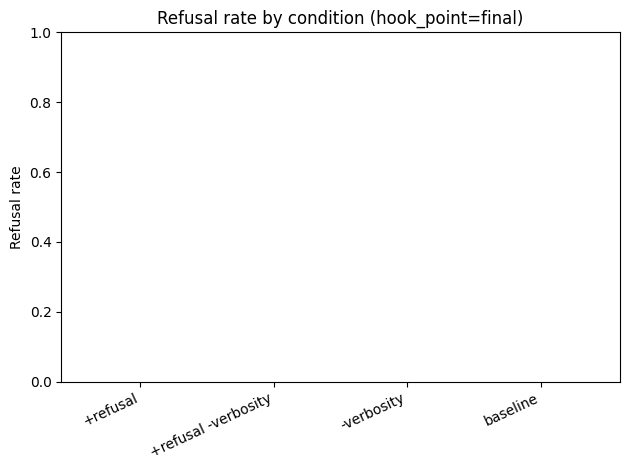

/tmp/ipython-input-4048267460.py:26: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



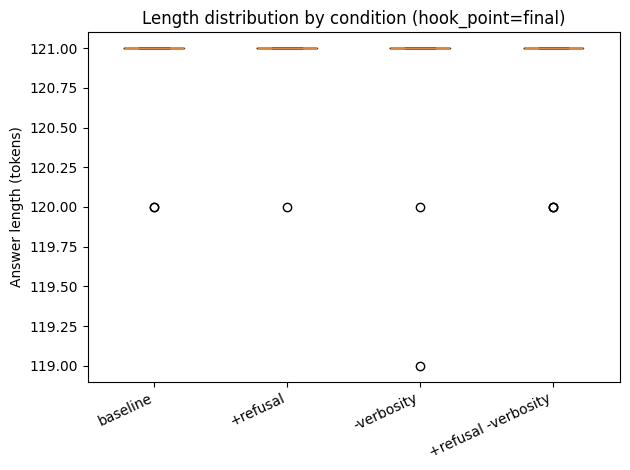

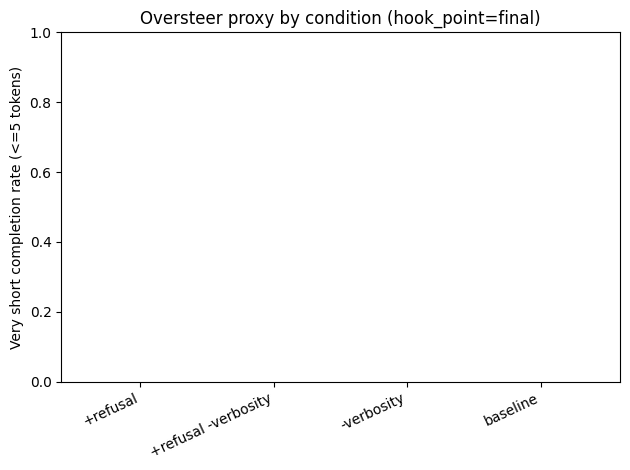

In [ ]:
# - If axes came from hook_resid_final, use hook_point="final"
# - If axes came from blocks.{layer}.hook_resid_post, use hook_point="layer" and set layer=...
HOOK_POINT = "final"   # change to "layer" if needed
LAYER = 10             # used only if HOOK_POINT="layer"

# Knob isolation experiment
df = eval_conditions(
    questions=BENIGN_QUESTIONS[:20],
    base_style="comply_verbose",
    max_new_tokens=120,
    hook_point=HOOK_POINT,
    layer=LAYER,
    conditions={
        "baseline": (0.0, 0.0),
        "+refusal": (2.0, 0.0),
        "-verbosity": (0.0, -2.0),
        "+refusal -verbosity": (2.0, -2.0),
    }
)

print(summarize_df(df))
plot_knob_isolation(df, title_suffix=f"(hook_point={HOOK_POINT})")

In [ ]:
df.to_csv("knob_isolation.csv", index=False)

In [ ]:
# Coefficient sweep heatmaps
grid = sweep_grid(
    questions=BENIGN_QUESTIONS[:16],
    base_style="comply_verbose",
    max_new_tokens=80,
    hook_point=HOOK_POINT,
    layer=LAYER,
    refusal_coeffs=(0.0, 1.0, 2.0, 3.0),
    verbosity_coeffs=(0.0, -1.0, -2.0, -3.0),
)

sweep_grid using hook: ln_final.hook_normalized


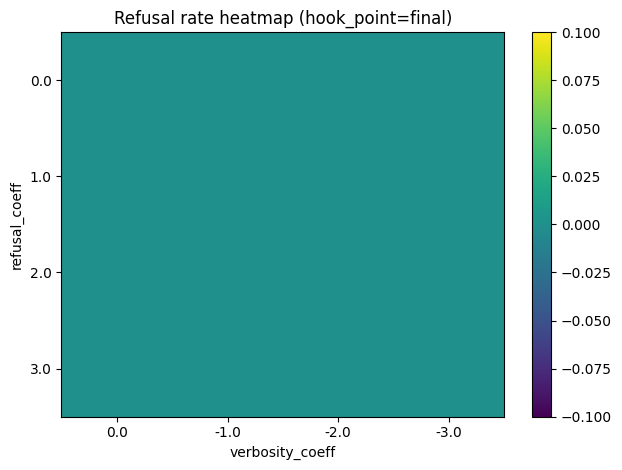

In [ ]:
plot_heatmap(
    grid["refusal_rate"],
    xlabels=grid["verbosity_coeffs"],
    ylabels=grid["refusal_coeffs"],
    title=f"Refusal rate heatmap (hook_point={HOOK_POINT})",
)

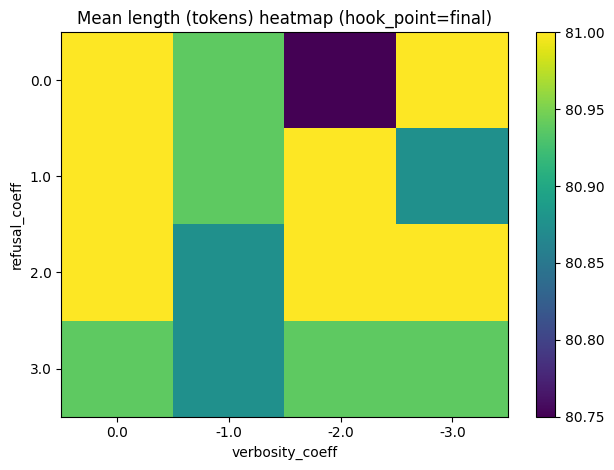

In [ ]:
plot_heatmap(
    grid["mean_len"],
    xlabels=grid["verbosity_coeffs"],
    ylabels=grid["refusal_coeffs"],
    title=f"Mean length (tokens) heatmap (hook_point={HOOK_POINT})",
)

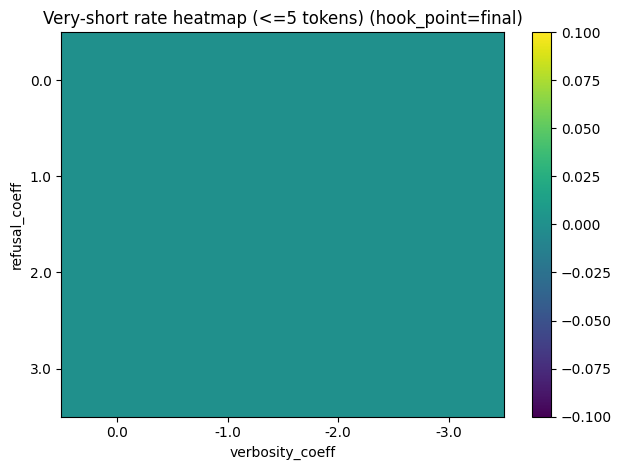

In [ ]:
plot_heatmap(
    grid["very_short_rate"],
    xlabels=grid["verbosity_coeffs"],
    ylabels=grid["refusal_coeffs"],
    title=f"Very-short rate heatmap (<=5 tokens) (hook_point={HOOK_POINT})",
)

In [ ]:
np.savez(
    "sweep_grid.npz",
    refusal_coeffs=np.array(grid["refusal_coeffs"]),
    verbosity_coeffs=np.array(grid["verbosity_coeffs"]),
    refusal_rate=grid["refusal_rate"],
    mean_len=grid["mean_len"],
    very_short_rate=grid["very_short_rate"],
)
